<a href="https://colab.research.google.com/github/Maiaryanraj/Sentiment-Analysis/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Topic: A Comparative Study of LSTM, Convolutional, and Transformer Models for Assessing Sentiment on Social Media

##Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

##Load the Sentiment140 Dataset

In [3]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/investigating-sentiment-analysis/data/training.1600000.processed.noemoticon.csv.zip -P data
!unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip

File ‘data/training.1600000.processed.noemoticon.csv.zip’ already there; not retrieving.

Archive:  data/training.1600000.processed.noemoticon.csv.zip


In [4]:
df = pd.read_csv("data/training.1600000.processed.noemoticon.csv",
                names=['target', 'ids', 'date', 'flag', 'user', 'text'],
                encoding='latin-1')
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## EDA

###Update target

Right now the target column is 0 for negative, 4 for positive. Let's change that to 0 and 1 to make things a little more reasonably readable.

In [5]:
df.target.value_counts()

,count
target,
0,800000
4,800000


In [6]:
# Map sentiment labels to 0 (negative), , and 1 (positive)
df['target'] = df['target'].map({0: 0, 4: 1})

In [7]:
df.target.value_counts()

,count
target,
0,800000
1,800000


### Remove unneeded columns

We don't need all those columns! Let's get rid of the ones that won't affect the sentiment.

In [8]:
df = df.drop(columns=['ids', 'date', 'flag', 'user'])
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [9]:
print('length of data is', len(df))

length of data is 1600000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [11]:
df.isna().sum()

,0
target,0
text,0


**Sentiment Distribution**
* Objective: Determine whether the dataset is balanced or biased toward a
particular sentiment.

* We'll visualize the count of each sentiment class using pie chart

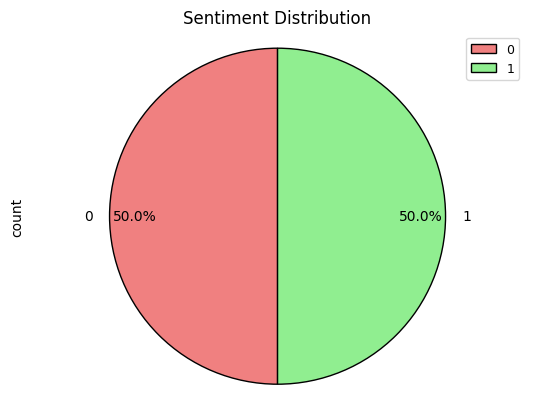

In [12]:
df["target"].value_counts().plot(kind="pie",
                                    autopct='%1.1f%%',
                                    pctdistance=0.85,
                                    startangle=90,
                                    colors=["lightcoral", "lightgreen"],
                                    wedgeprops={'edgecolor': 'black'})

plt.title('Sentiment Distribution')
plt.axis('equal')
plt.legend(labels=df["target"].value_counts().index,
           loc='upper right', fontsize=9)
plt.show()

**Most Common Words in Each Sentiment (Word Clouds)**

* Objective: Identify words commonly associated with positive and negative
sentiments.
* A word cloud is a great way to see the most frequent words in each sentiment category.
* This helps us understand what kind of words contribute to positive or negative emotions.

### Cleaning tweets

In [13]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)           # remove URLs
    text = re.sub(r'@\w+', '', text)              # remove mentions
    text = re.sub(r'#', '', text)                 # remove hashtags symbol
    text = re.sub(r'[^\w\s]', '', text)           # remove punctuation
    text = text.lower().strip()                   # lowercase and strip
    return text

df['clean_text'] = df['text'].apply(clean_text)


**word cloud for positive sentiment**

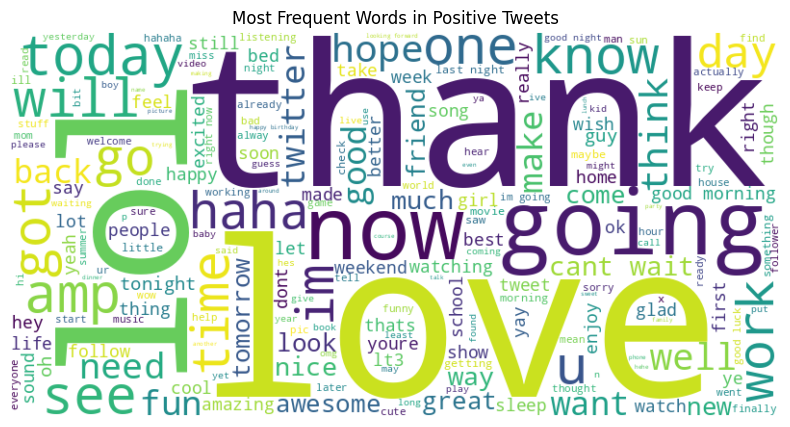

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_words = " ".join(df[df["target"] == 1]["clean_text"])
negative_words = " ".join(df[df["target"] == 0]["clean_text"])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_words)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Positive Tweets")
plt.show()

**word cloud for negative sentiment**

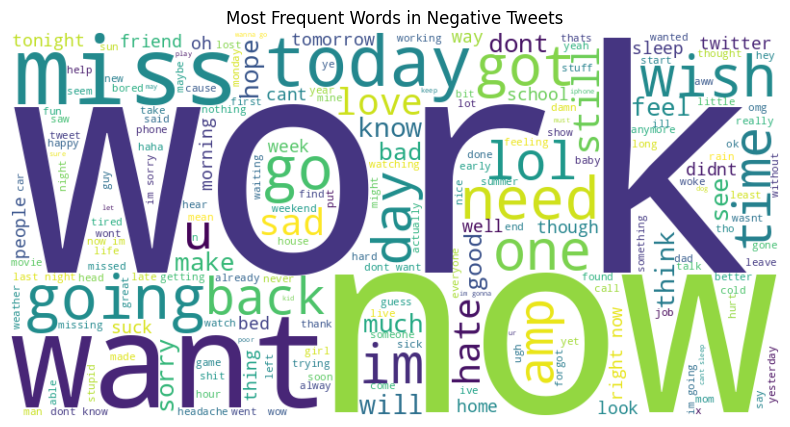

In [14]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(negative_words)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Negative Tweets")
plt.show()

### Tokenization and Padding

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set parameters
vocab_size = 20000  # You can adjust this
max_length = 50     # Typical tweet length
oov_token = "<OOV>"

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df['clean_text'])

# Convert tweets to sequences
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

## Data Modelling

In [15]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df["target"], test_size=0.2, random_state=42)


### LSTM
####Building the Model (LSTM)

In [16]:
vocab_size = len(tokenizer.word_index) + 1
max_length = 50
embedding_dim = 100

In [18]:
from tensorflow.keras.layers import Dense,Input,Embedding,Dropout,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization,SimpleRNN,LSTM,SpatialDropout1D

In [19]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_shape=(max_length,)),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 128)        │    57,707,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,847,041 (220.67 MB)

 Trainable params: 57,847,041 (220.67 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Train the Model

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [22]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 314s 39ms/step - accuracy: 0.6589 - loss: 0.5661 - val_accuracy: 0.8176 - val_loss: 0.4008
Epoch 2/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 319s 39ms/step - accuracy: 0.8252 - loss: 0.3895 - val_accuracy: 0.8230 - val_loss: 0.3893
Epoch 3/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 317s 38ms/step - accuracy: 0.8410 - loss: 0.3581 - val_accuracy: 0.8260 - val_loss: 0.3864
Epoch 4/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 321s 38ms/step - accuracy: 0.8545 - loss: 0.3321 - val_accuracy: 0.8253 - val_loss: 0.3900
Epoch 5/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 303s 38ms/step - accuracy: 0.8679 - loss: 0.3060 - val_accuracy: 0.8212 - val_loss: 0.4130


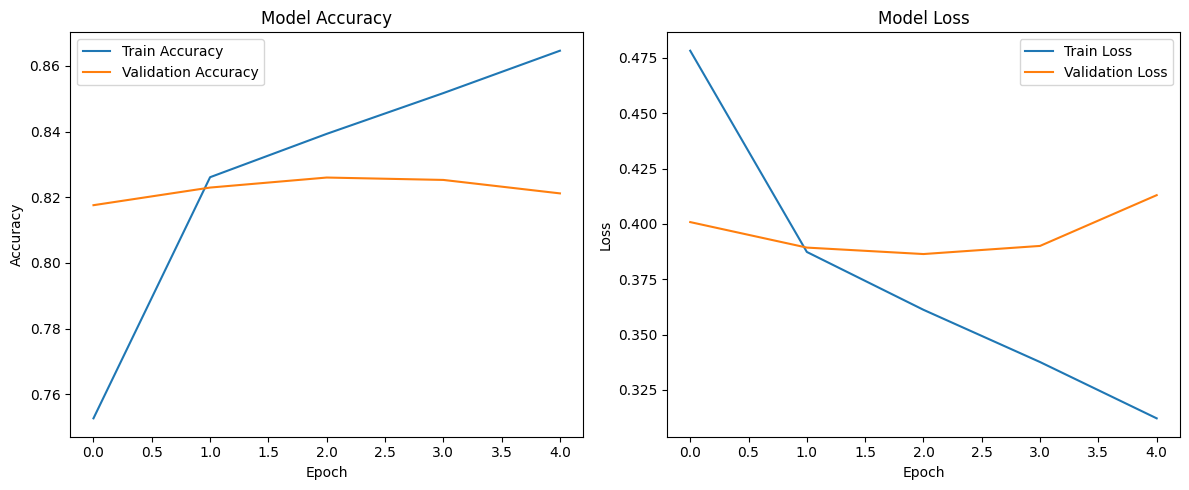

In [23]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#### Evaluate LSTM on Test Data

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8254 - loss: 0.3862
Test Loss: 0.3864
Test Accuracy: 0.8256
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
              precision    recall  f1-score   support

    Negative       0.83      0.82      0.82    159494
    Positive       0.82      0.83      0.83    160506

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



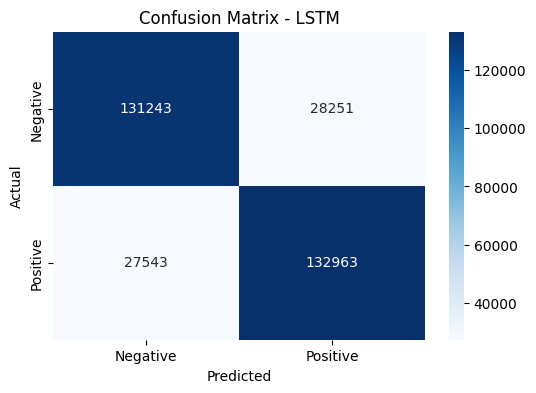

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predict the labels
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()

### CNN
#### Build and Compile CNN Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# CNN model
cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(max_length,)),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 100)        │    45,083,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 46, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,149,129 (172.23 MB)

 Trainable params: 45,149,129 (172.23 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the Model

In [26]:
cnn_history = cnn_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1  # 0 = silent, 1 = progress bar, 2 = one line per epoch
)

Epoch 1/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 111s 13ms/step - accuracy: 0.7766 - loss: 0.4663 - val_accuracy: 0.8164 - val_loss: 0.4046
Epoch 2/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 107s 13ms/step - accuracy: 0.8240 - loss: 0.3906 - val_accuracy: 0.8204 - val_loss: 0.3959
Epoch 3/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 107s 13ms/step - accuracy: 0.8367 - loss: 0.3655 - val_accuracy: 0.8207 - val_loss: 0.3977
Epoch 4/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 140s 13ms/step - accuracy: 0.8472 - loss: 0.3453 - val_accuracy: 0.8199 - val_loss: 0.4027


#### Evaluate the Model

In [27]:
# Evaluate on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.8189 - loss: 0.3967
Test Loss: 0.3972
Test Accuracy: 0.8193


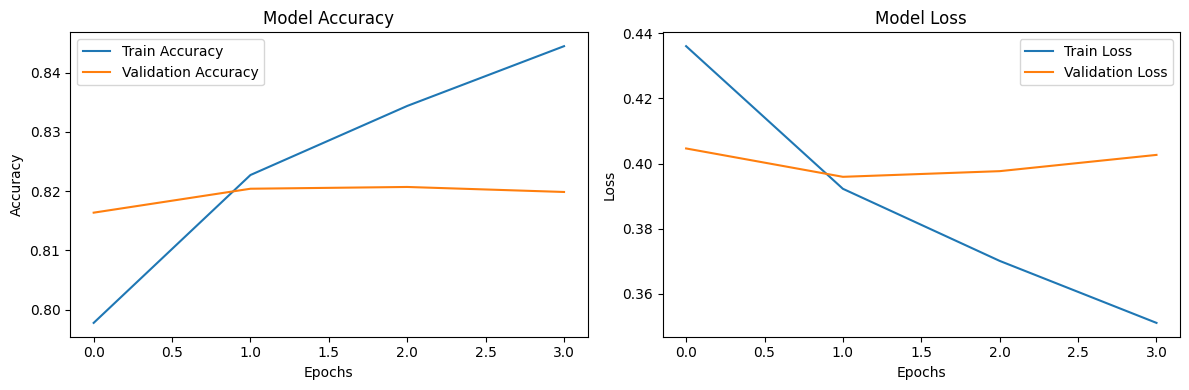

In [28]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Transformer Models

##### DistilBERT

Convert Data to DistilBERT Input Format

In [18]:
train_texts = X_train.astype(str).tolist()
val_texts = X_test.astype(str).tolist()
test_texts = X_test.astype(str).tolist()

# Ensure labels are lists of integers
train_labels = y_train.tolist()
val_labels = y_test.tolist()
test_labels = y_test.tolist()

# Convert list of numbers (token IDs) to list of strings for DistilBERT to process
train_texts = [' '.join(text) for text in train_texts]
val_texts = [' '.join(text) for text in val_texts]
test_texts = [' '.join(text) for text in test_texts]

In [19]:
from transformers import InputExample, InputFeatures

In [21]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

Tokenization with DistilBERT

In [ ]:
distil_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = distil_tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = distil_tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)


train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    list(train_labels)
)).take(15000).batch(16).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    list(val_labels)
)).take(3000).batch(16).prefetch(tf.data.AUTOTUNE)

Load DistilBERT Model

In [24]:
distil_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Compile and Train the Model

In [26]:
distil_model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
distil_model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# Training loop
epochs = 4
patience = 1
wait = 0
best_val_loss = float('inf')

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    distil_model.fit(train_dataset, epochs=1, verbose=1)
    val_loss, val_acc = distil_model.evaluate(val_dataset, verbose=0)
    print(f"Val loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        distil_model.save_weights('best_distilbert_model_weights.h5')
        print("✅ Weights saved.")
    else:
        wait += 1
        print(f"⚠️ Patience: {wait}/{patience}")
        if wait >= patience:
            print("🛑 Early stopping.")
            break

distil_model.load_weights('best_distilbert_model_weights.h5')
print("✅ Best weights loaded.")


Epoch 1/4
938/938 [==============================] - 161s 145ms/step - loss: 0.7000 - accuracy: 0.5045
Val loss: 0.6931 | Acc: 0.4957
✅ Weights saved.

Epoch 2/4
938/938 [==============================] - 135s 144ms/step - loss: 0.6932 - accuracy: 0.5041
Val loss: 0.6931 | Acc: 0.4957
⚠️ Patience: 1/1
🛑 Early stopping.
✅ Best weights loaded.


### Model Evaluation and Comparison

#### Define Evaluation Function

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, tokenizer, texts, labels, is_transformer=False):
    if is_transformer:
        encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128, return_tensors='tf')
        preds = model.predict(encodings).logits
    else:
        preds = model.predict(texts)

    predicted_labels = tf.math.argmax(preds, axis=1).numpy()

    print(classification_report(labels, predicted_labels, target_names=["Negative", "Positive"]))

    cm = confusion_matrix(labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()


#### Evaluate DistilBERT Model

10000/10000 [==============================] - 859s 86ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67    159494
    Positive       0.00      0.00      0.00    160506

    accuracy                           0.50    320000
   macro avg       0.25      0.50      0.33    320000
weighted avg       0.25      0.50      0.33    320000



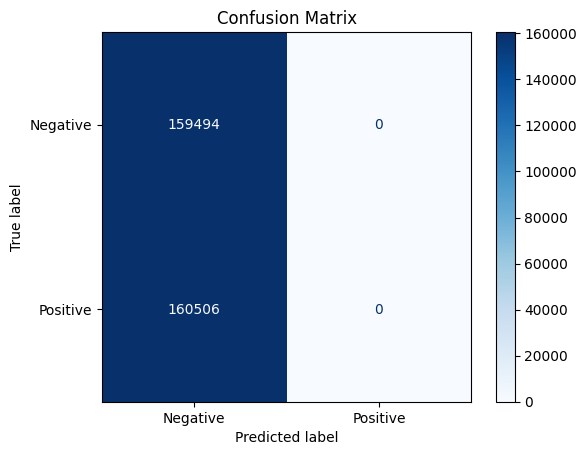

In [33]:
# For LSTM and CNN (assuming they use padded sequences as input)
#evaluate_model(model, None, X_val, val_labels)
#evaluate_model(cnn_model, None, X_val, val_labels)

# For DistilBERT
evaluate_model(distil_model, distil_tokenizer, val_texts, val_labels, is_transformer=True)


#### Plot Model Accuracy

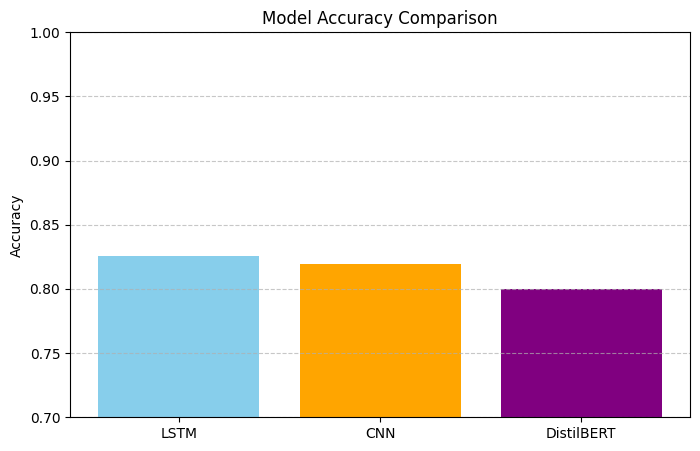

In [36]:
import numpy as np

# Example accuracies, replace with actual values from model.history or manual tracking
model_names = ['LSTM', 'CNN', 'DistilBERT']
accuracies = [0.8256, 0.8193, 0.8]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['skyblue', 'orange', 'purple'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0.7, 1.0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
